<a href="https://colab.research.google.com/github/fernandobatistti/Special-Topics-in-Applied-Physics---Project-I/blob/main/Code/Projeto_I_C%C3%B3digo_Fonte.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INSTITUTO LATINO-AMERICANO DECIÊNCIAS DA VIDA E DA NATUREZA (ILACVN)

Curso: Física Aplicada

Disciplina: FIS0006 - TÓPICOS ESPECIAIS EM FÍSICA EXPERIMENTAL

Professor Dr. JOYLAN NUNES MACIEL





Projeto I: Previsão da Severidade do Câncer



Estudante:
Fernando José Zardinello Batistti 	(2024101000016465)




Foz do Iguaçu, 6 de junho de 2025.



# Projeto I - Previsão da Severidade do Câncer

In [ ]:
###0 Bibliotecas que serão utilizadas:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
import joblib
import os # Biblioteca para interagir com o sistema operacional, como criar pastas

## 1) Coleta de dados

In [ ]:
### 1. Coleta de Dados
from google.colab import drive

# Monta o Google Drive
drive.mount('/content/drive', force_remount=True)

# Caminho para o arquivo no seu Drive
caminho_arquivo = '/content/drive/MyDrive/Tópicos Especiais Em Física Experimental/Projeto I/Dados/global_cancer_patients_2015_2024.csv'

# Carrega os dados
df = pd.read_csv(caminho_arquivo)

# Exibe uma amostra dos dados
print("--- Amostra do Dataset ---")
display(df.head())

Mounted at /content/drive
--- Amostra do Dataset ---


,Patient_ID,Age,Gender,Country_Region,Year,Genetic_Risk,Air_Pollution,Alcohol_Use,Smoking,Obesity_Level,Cancer_Type,Cancer_Stage,Treatment_Cost_USD,Survival_Years,Target_Severity_Score
0,PT0000000,71,Male,UK,2021,6.4,2.8,9.5,0.9,8.7,Lung,Stage III,62913.44,5.9,4.92
1,PT0000001,34,Male,China,2021,1.3,4.5,3.7,3.9,6.3,Leukemia,Stage 0,12573.41,4.7,4.65
2,PT0000002,80,Male,Pakistan,2023,7.4,7.9,2.4,4.7,0.1,Breast,Stage II,6984.33,7.1,5.84
3,PT0000003,40,Male,UK,2015,1.7,2.9,4.8,3.5,2.7,Colon,Stage I,67446.25,1.6,3.12
4,PT0000004,43,Female,Brazil,2017,5.1,2.8,2.3,6.7,0.5,Skin,Stage III,77977.12,2.9,3.62


## 2) Limpeza e pré-processamento de dados

In [ ]:
### 2. Limpeza e Pré-processamento de Dados

# Informações gerais sobre o dataset (tipos de dados, contagem de nulos)
print("--- Informações Gerais do Dataset ---")
df.info()

# Remover a coluna de ID do paciente, pois não tem valor preditivo
if 'Patient_ID' in df.columns:
    df = df.drop('Patient_ID', axis=1)
    print("\nColuna 'Patient_ID' removida.")

# Verificar novamente a contagem de valores nulos após qualquer limpeza
print("\n--- Verificação de Valores Nulos ---")
print(df.isnull().sum())
# Se houvesse valores nulos, teríamos que decidir como tratá-los (remover ou preencher).
# Neste caso, o dataset está limpo.

--- Informações Gerais do Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Patient_ID             50000 non-null  object 
 1   Age                    50000 non-null  int64  
 2   Gender                 50000 non-null  object 
 3   Country_Region         50000 non-null  object 
 4   Year                   50000 non-null  int64  
 5   Genetic_Risk           50000 non-null  float64
 6   Air_Pollution          50000 non-null  float64
 7   Alcohol_Use            50000 non-null  float64
 8   Smoking                50000 non-null  float64
 9   Obesity_Level          50000 non-null  float64
 10  Cancer_Type            50000 non-null  object 
 11  Cancer_Stage           50000 non-null  object 
 12  Treatment_Cost_USD     50000 non-null  float64
 13  Survival_Years         50000 non-null  float64
 14  Target_Severity_

## 3) Análise Exploratória de Dados (EDA)

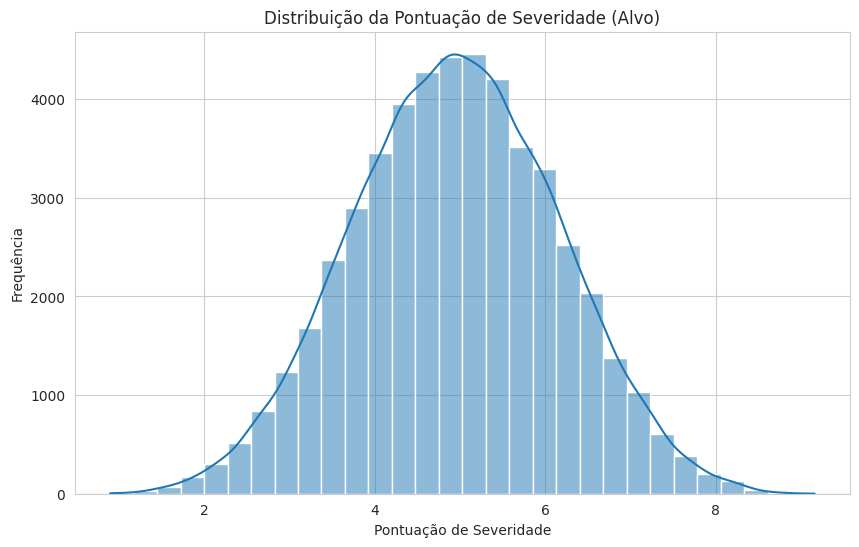

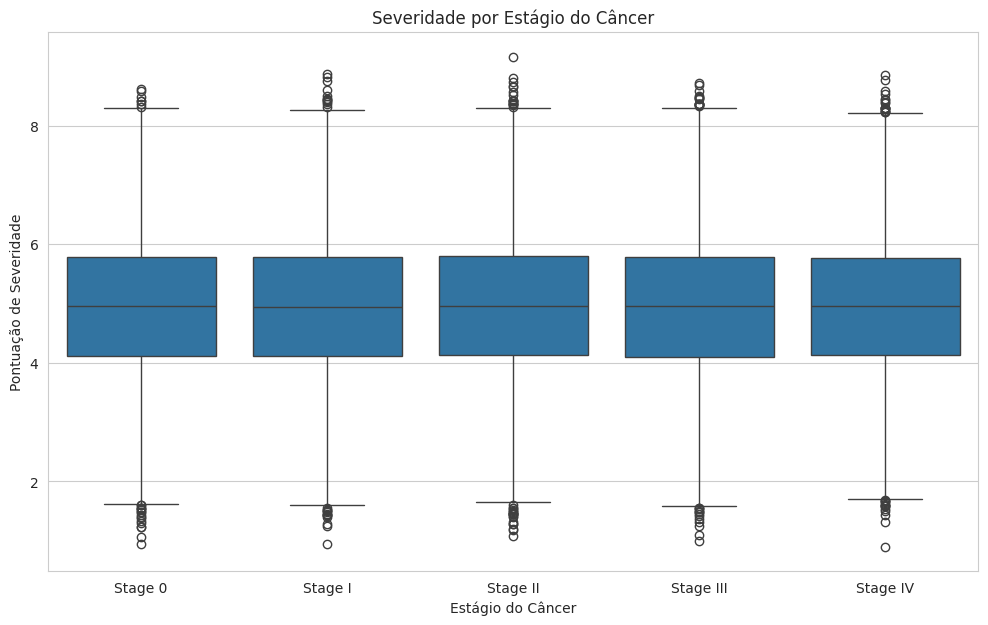

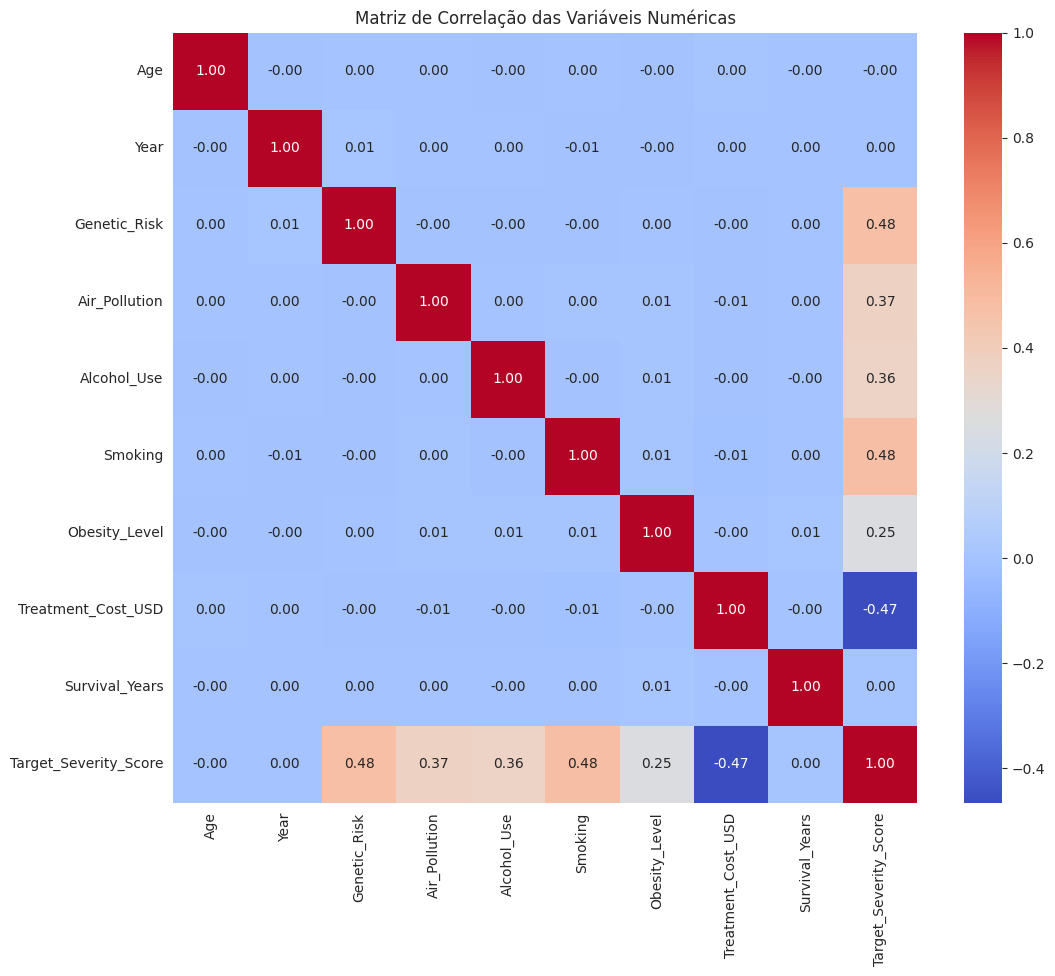

In [ ]:
### 3. Análise Exploratória de Dados (EDA)

# Configurações de estilo para os gráficos
sns.set_style("whitegrid")

# Histograma da variável alvo para entender sua distribuição
plt.figure(figsize=(10, 6))
sns.histplot(df['Target_Severity_Score'], kde=True, bins=30)
plt.title('Distribuição da Pontuação de Severidade (Alvo)')
plt.xlabel('Pontuação de Severidade')
plt.ylabel('Frequência')
plt.show()
plt.figure(figsize=(12, 7))

# Função auxiliar para converter o estágio do câncer (com numeral romano) para um número
def get_stage_value(stage_str):
    if not isinstance(stage_str, str) or 'Stage' not in stage_str:
        return -1 # Retorna um valor padrão para dados inesperados

    roman_map = {'I': 1, 'II': 2, 'III': 3, 'IV': 4}

    # Pega a última parte da string (ex: 'III' de 'Stage III')
    number_part = stage_str.split()[-1]

    # Tenta converter diretamente para int (para o caso de 'Stage 0')
    try:
        return int(number_part)
    # Se falhar, é porque é um numeral romano
    except ValueError:
        return roman_map.get(number_part, -1) # Usa o mapa para converter

# Obtém os estágios únicos e ordena usando a nova função como chave
unique_stages = df['Cancer_Stage'].unique()
stage_order = sorted(unique_stages, key=get_stage_value)
sns.boxplot(x='Cancer_Stage', y='Target_Severity_Score', data=df, order=stage_order)
plt.title('Severidade por Estágio do Câncer')
plt.xlabel('Estágio do Câncer')
plt.ylabel('Pontuação de Severidade')
plt.show()


# Matriz de correlação para as variáveis numéricas
plt.figure(figsize=(12, 10))
numeric_cols = df.select_dtypes(include=np.number).columns
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação das Variáveis Numéricas')
plt.show()

## 4) Engenharia de Características (*Feature Engineering*)

In [ ]:
### 4. Engenharia de Características (Feature Engineering)

# Separar as features (X) e o alvo (y)
X = df.drop('Target_Severity_Score', axis=1)
y = df['Target_Severity_Score']

# Identificar colunas numéricas e categóricas
numerical_features = X.select_dtypes(include=np.number).columns
categorical_features = X.select_dtypes(exclude=np.number).columns

# Criar o pipeline de pré-processamento
# Para features numéricas: normalização
numeric_transformer = StandardScaler()
# Para features categóricas: one-hot encoding
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Usar ColumnTransformer para aplicar transformações diferentes a colunas diferentes
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Mantém colunas não especificadas (se houver)
)

print("Pipeline de pré-processamento criado com sucesso.")

Pipeline de pré-processamento criado com sucesso.


## 5) Divisão do dataset (treinamento e teste)

In [ ]:
### 5. Divisão do dataset (treinamento e teste)

# Dividir os dados ANTES de aplicar o pré-processamento para evitar vazamento de dados
X_treino, X_teste, y_treino, y_teste = train_test_split(
    X, y,
    test_size=0.2, # 20% para teste
    random_state=42 # Semente aleatória para reprodutibilidade
)

print("Dados divididos em conjuntos de treino e teste:")
print("X_treino:", X_treino.shape)
print("X_teste:", X_teste.shape)

Dados divididos em conjuntos de treino e teste:
X_treino: (40000, 13)
X_teste: (10000, 13)


## 6) Escolha do Modelo

In [ ]:
### 6. Escolha do Modelo

# O modelo escolhido é o RandomForestRegressor.
# Vamos criar o pipeline final que inclui o pré-processador e o modelo.
# Isso garante que o pré-processamento seja ajustado APENAS nos dados de treino.
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])
#Os hiperparâmetros padrões são:
#n_estimators: 100
#max_depth: None (significa que as árvores crescem até que todas as folhas sejam "puras", o que pode levar a árvores muito profundas e overfitting)
#min_samples_split: 2 (um nó precisa ter no mínimo 2 amostras para poder ser dividido)
#min_samples_leaf: 1 (uma folha final precisa ter no mínimo 1 amostra)
print("Modelo (RandomForestRegressor) e pipeline final definidos.")

Modelo (RandomForestRegressor) e pipeline final definidos.


## 7) Implementação, treinamento (e validação, alguns modelos)

--- Treinando o modelo ---
Treinamento concluído.

--- Gerando Curvas de Aprendizado ---


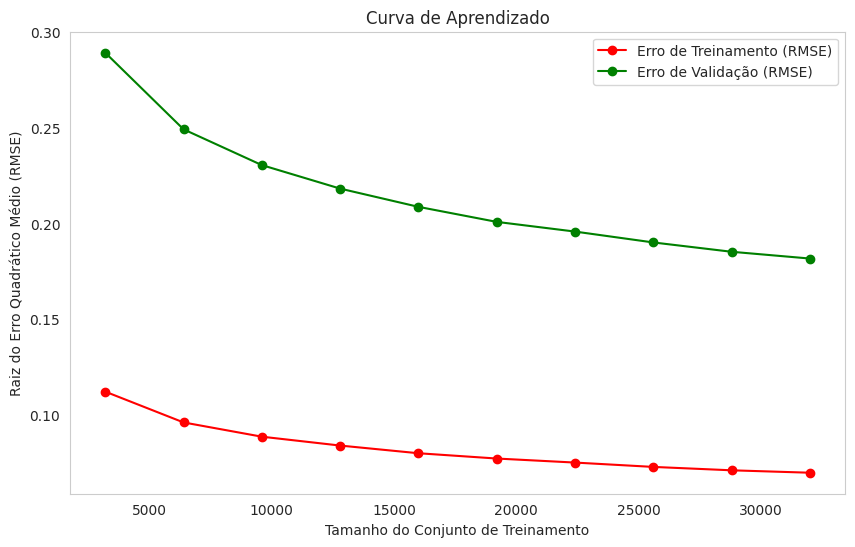

In [ ]:
### 7. Implementação, treinamento e validação

# Treinar o pipeline completo (pré-processamento + modelo)
print("--- Treinando o modelo ---")
model_pipeline.fit(X_treino, y_treino)
print("Treinamento concluído.")

# --- Gerando Curvas de Aprendizado ---
print("\n--- Gerando Curvas de Aprendizado ---")
train_sizes, train_scores, test_scores = learning_curve(
    estimator=model_pipeline,
    X=X_treino,
    y=y_treino,
    cv=5, # 5-fold cross-validation
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='neg_mean_squared_error' # Métrica de erro para regressão
)

# Converter o erro (que é negativo) para positivo e tirar a raiz para ter o RMSE
train_scores_mean = np.mean(np.sqrt(-train_scores), axis=1)
test_scores_mean = np.mean(np.sqrt(-test_scores), axis=1)

# Plotar a curva
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Erro de Treinamento (RMSE)")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Erro de Validação (RMSE)")
plt.title("Curva de Aprendizado")
plt.xlabel("Tamanho do Conjunto de Treinamento")
plt.ylabel("Raiz do Erro Quadrático Médio (RMSE)")
plt.legend(loc="best")
plt.grid()
plt.show()

## 8) Avaliação com dados de teste

--- Métricas de Avaliação no Conjunto de Teste ---
Mean Absolute Error (MAE): 0.136
Mean Squared Error (MSE): 0.030
Root Mean Squared Error (RMSE): 0.172
R-squared (R²): 0.979


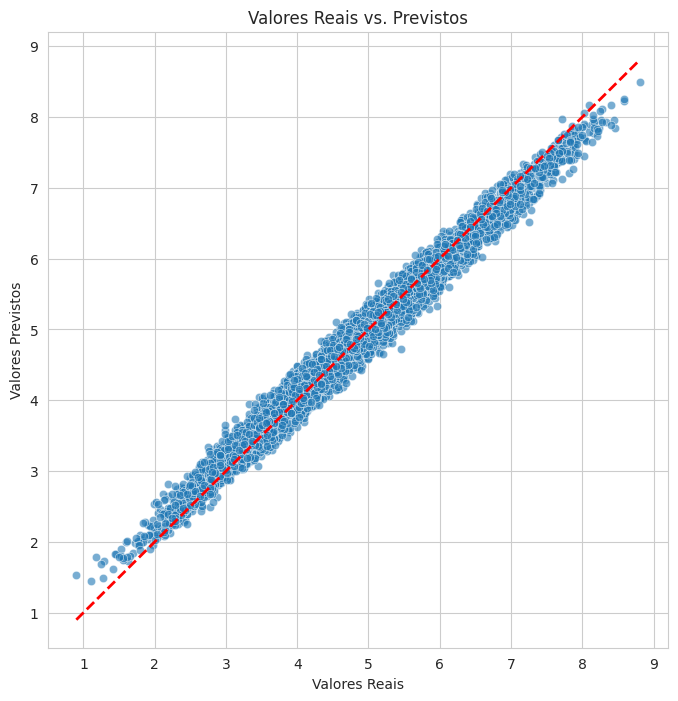

In [ ]:
### 8. Avaliação com dados de teste

# Fazer previsões no conjunto de teste
previsoes = model_pipeline.predict(X_teste)

# Calcular as métricas de avaliação
mae = mean_absolute_error(y_teste, previsoes)
mse = mean_squared_error(y_teste, previsoes)
rmse = np.sqrt(mse)
r2 = r2_score(y_teste, previsoes)

print("--- Métricas de Avaliação no Conjunto de Teste ---")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"R-squared (R²): {r2:.3f}")

# Gráfico de Dispersão: Valores Reais vs. Previstos
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_teste, y=previsoes, alpha=0.6)
# Linha de referência para uma previsão perfeita
plt.plot([y_teste.min(), y_teste.max()], [y_teste.min(), y_teste.max()], '--r', linewidth=2)
plt.title('Valores Reais vs. Previstos')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Previstos')
plt.show()

## 9) Otimização e ajuste de hiperparâmetros (*Fine Tunning*)

In [ ]:
### 9. Otimização e ajuste de hiperparâmetros

# Definir o espaço de hiperparâmetros a ser testado
param_dist = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [10, 20, 30, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

# Configurar a busca aleatória com validação cruzada
random_search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

print("--- Iniciando a Otimização de Hiperparâmetros ---")
random_search.fit(X_treino, y_treino)

print("\n--- Melhores Hiperparâmetros Encontrados ---")
print(random_search.best_params_)

# Avaliar o melhor modelo encontrado pela busca
print("\n--- Avaliação do Melhor Modelo Otimizado no Teste ---")
best_model = random_search.best_estimator_
previsoes_otimizadas = best_model.predict(X_teste)

# Calcular TODAS as métricas para o modelo otimizado
mae_otimizado = mean_absolute_error(y_teste, previsoes_otimizadas)
mse_otimizado = mean_squared_error(y_teste, previsoes_otimizadas)
rmse_otimizado = np.sqrt(mse_otimizado)
r2_otimizado = r2_score(y_teste, previsoes_otimizadas)

# Exibir todas as métricas formatadas
print(f"Mean Absolute Error (MAE) otimizado: {mae_otimizado:.3f}")
print(f"Root Mean Squared Error (RMSE) otimizado: {rmse_otimizado:.3f}")
print(f"R-squared (R²) otimizado: {r2_otimizado:.3f}")
# ==============================================================================

--- Iniciando a Otimização de Hiperparâmetros ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits

--- Melhores Hiperparâmetros Encontrados ---
{'regressor__n_estimators': 300, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 1, 'regressor__max_depth': None}

--- Avaliação do Melhor Modelo Otimizado no Teste ---
Mean Absolute Error (MAE) otimizado: 0.136
Root Mean Squared Error (RMSE) otimizado: 0.171
R-squared (R²) otimizado: 0.979


## 10) Implantação, validação e monitoramento

In [ ]:
### 10. Implantação, Validação e Monitoramento (com Salvamento do Modelo)

# --- ETAPA DE SALVAMENTO DO MODELO ---

# 1. DEFINIR O CAMINHO E O NOME DO ARQUIVO
caminho_da_pasta = '/content/drive/MyDrive/Tópicos Especiais Em Física Experimental/Projeto I/Modelo'
nome_do_arquivo = 'modelo_previsao_severidade_cancer_v1.joblib'
caminho_completo = os.path.join(caminho_da_pasta, nome_do_arquivo)

# 2. CRIAR A PASTA, CASO ELA NÃO EXISTA
# O 'exist_ok=True' evita um erro caso a pasta já tenha sido criada.
os.makedirs(caminho_da_pasta, exist_ok=True)

# 3. IDENTIFICAR O MELHOR MODELO
# O melhor modelo é aquele encontrado pelo RandomizedSearchCV no passo 9.
melhor_modelo_final = random_search.best_estimator_

# 4. SALVAR O MODELO NO CAMINHO ESPECIFICADO
# Usamos joblib.dump para salvar o objeto do modelo no arquivo.
joblib.dump(melhor_modelo_final, caminho_completo)

print(f"Modelo salvo com sucesso em: {caminho_completo}")

Modelo salvo com sucesso em: /content/drive/MyDrive/Tópicos Especiais Em Física Experimental/Projeto I/Modelo/modelo_previsao_severidade_cancer_v1.joblib
